In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
        root='.',
        train=True,
        transform=transforms.ToTensor(),
        download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [8]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
test_dataset = torchvision.datasets.FashionMNIST(
        root='.',
        train=False,
        transform=transforms.ToTensor(),
        download=True)

In [10]:
# number o classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [ ]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K))
        
      # this where we actually pass a given input through the CNN
    def forward(self, X):
        out = self.conv_layers(X)
        #print(out.size())
        # out.size(0) refers to batch_size. prevent batch_size and flat other dimention to ingest linear layer
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [52]:
# instantiate the model
model = CNN(K)

In [44]:
# The same model

# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, outchannels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K)
# )

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [54]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [55]:
# Data loader
# generates batch and shuffle

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

In [58]:
def batch_dg(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
    
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
        Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    return train_losses, test_losses

In [59]:
 train_losses, test_losses = batch_dg(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.4907,         Test Loss: 0.4383, Duration: 0:00:13.200615
Epoch 2/15, Train Loss: 0.3945,         Test Loss: 0.3944, Duration: 0:00:13.228813
Epoch 3/15, Train Loss: 0.3512,         Test Loss: 0.3744, Duration: 0:00:13.169120
Epoch 4/15, Train Loss: 0.3186,         Test Loss: 0.3497, Duration: 0:00:13.332121
Epoch 5/15, Train Loss: 0.2957,         Test Loss: 0.3395, Duration: 0:00:13.334196
Epoch 6/15, Train Loss: 0.2753,         Test Loss: 0.3216, Duration: 0:00:13.200260
Epoch 7/15, Train Loss: 0.2576,         Test Loss: 0.3151, Duration: 0:00:13.158587
Epoch 8/15, Train Loss: 0.2392,         Test Loss: 0.3289, Duration: 0:00:13.208317
Epoch 9/15, Train Loss: 0.2263,         Test Loss: 0.2983, Duration: 0:00:13.129554
Epoch 10/15, Train Loss: 0.2131,         Test Loss: 0.3070, Duration: 0:00:13.169111
Epoch 11/15, Train Loss: 0.2020,         Test Loss: 0.3091, Duration: 0:00:13.220998
Epoch 12/15, Train Loss: 0.1918,         Test Loss: 0.3224, Duration: 0:00

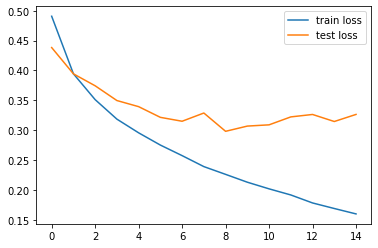

In [60]:
# plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [66]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    # print(outputs.shape) ===> [128, 10]
    # torch.max returns a namedtuple (values, indices) where values is the maximum value of each row of the input tensor
    # in the given dimension dim. And indices is the index location of each maximum value found (argmax)
    # get prediction
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total
    
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total  
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9471, Test acc: 0.9404


In [87]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, newaxis]
        print('Normlized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normaliztion')
                                         
    print(cm)                                     
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
                                         
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()                                     

Confusion Matrix, Without Normaliztion
[[856   2  37  20   6   2  72   0   5   0]
 [  5 972   1  17   3   0   1   0   1   0]
 [ 15   0 876  12  57   1  38   0   1   0]
 [ 16   3  20 915  23   1  16   0   6   0]
 [  0   0  45  32 880   0  40   0   3   0]
 [  1   0   0   1   0 976   0  13   2   7]
 [119   0  85  28 117   0 639   0  12   0]
 [  0   0   0   0   0  20   0 953   2  25]
 [  2   0   5   1   5   1   2   3 980   1]
 [  0   0   0   0   0   5   0  26   0 969]]


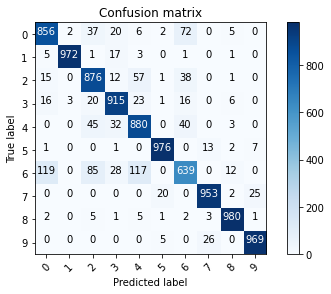

In [88]:
# get all predictions in an array and plot confuion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])


for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm , list(range(10)))

In [89]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

Text(0.5, 1.0, 'True label: Pullover Predicted label: Shirt')

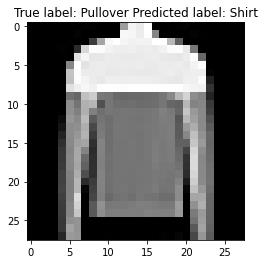

In [93]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
missclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(missclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted label: %s" % (labels[y_test[i]], labels[p_test[i]]))